In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.datasets import QM9, TUDataset, ZINC, Planetoid, Amazon, Coauthor, CitationFull
from torch_geometric.loader import DataLoader
from ogb.nodeproppred import PygNodePropPredDataset
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# 분위수 정보를 노드 특징에 포함 : 분위수 값 자체가 학습을 안정적으로 유도할 수 있도록 추가
# 분위수 정보 확장을 위한 데이터 변환
# 분위수 정보를 추가하여 GNN이 입력 특성에서 분위수를 학습 가능하도록 변경
# 값의 스케일링을 조정(12배 확대)하여 학습 안정성을 증가(Sigmoid 영역 내 활용)
# expand()를 사용하여 차원 유지
# tau는 분위수 이로 기본적으로 0~1 사이의 값이다.
# 하지만 딥러닝 모델은 일반적으로 입력값이 너무 작거나 큰 경우, 학습이 어려워지는 문제가 발생
#  0~1 범위의 값은 매우 작기 때문에 신경망의 활성화 함수(예: ReLU, tanh)에서 거의 변화를 일으키지 않을 수도 있습니다.
# 많은 머신러닝 모델(특히 신경망)은 입력 특징이 평균 0, 적절한 분산을 가지면 학습이 잘 됨.
# 표준 정규분포(평균 0, 표준편차 1)의 경우 ±3σ 구간(약 99.7%의 데이터)은 대략 -3 ~ 3 범위에 있음.
# 12는 일반적인 딥러닝 모델이 잘 학습하는 값의 범위(-6 ~ 6)를 만들기 위한 경험적인 값으로 보입니다.

# GCN 구조로 설계
# 여러 GNN 구조 중 GCN이 실험적으로 예측 안정성이 더 높은 경우가 많음
# GNN 기반 분위수 예측 모델
# 이 모델은 그래프 신경망(GNN) 중 하나인 GCN (Graph Convolutional Network) 기반으로, 특정 분위수(Quantile) 값을 예측하는 모델입니다. 
# 즉, 각 노드의 값을 "여러 분위수"로 예측할 수 있도록 설계된 그래프 신경망입니다.

# Coverage 조정 메커니즘 추가 : Coverage 보장이 부족할 경우 신뢰 구간을 자동 조정
# Coverage 보장을 위한 동적 분위수 조정 (DQA)
# Coverage가 부족하면 신뢰 구간을 넓히고, Coverage가 과하면 구간을 줄이는 방식으로 업데이트

# 분위수 손실 함수 (Coverage + PIW 최적화 포함)
# PIW 최적화 추가 : 신뢰 구간 폭을 줄이는 손실항을 추가하여 최적화

In [129]:
def augment_features(x, tau, scale_factor=12):
    """
    분위수 값을 학습 데이터에 추가하여 GNN이 학습할 수 있도록 변환하는 함수.
    
    Args:
        x (torch.Tensor): 원래 입력 특징값 (batch_size, feature_dim)
        tau (torch.Tensor): 분위수 값 (batch_size, 1)
        scale_factor (float): 분위수 값의 변환을 조절하는 스케일링 계수 (기본값: 12)
        
    Returns:
        torch.Tensor: 변환된 입력 특징값 (batch_size, feature_dim + 1)
    """
    tau = tau.view(-1, 1)  # tau를 (batch_size, 1) 형태로 변환
    tau_transformed = (tau - 0.5) * scale_factor  # 분위수 값 변환 (값의 범위를 조절하여 학습 안정성 증가)
    return torch.cat((x, tau_transformed.expand(x.size(0), -1)), dim=1)

class GCNQuantile(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GCNQuantile, self).__init__()
        self.conv1 = GCNConv(in_channels + 1, hidden_channels)  # 분위수 값을 포함한 입력
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels, 1) # 단일 분위수 학습을 위한 출력층

    def forward(self, x, edge_index, tau):
        x = augment_features(x, tau)
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return x

def cvg_loss(y_true, y_low, y_high, cvg_target=0.9):
    cvg_exp = ((y_true >= y_low) & (y_true <= y_high)).float().mean()
    return (cvg_exp - cvg_target) ** 2

def pi_loss(y_low, y_high):
    return torch.mean(y_high - y_low)  # PI 평균
           
class QuantileLoss(nn.Module):
    def __init__(self):
        super(QuantileLoss, self).__init__()

    def forward(self, y_pred, y_true, tau):
        diff = y_true - y_pred  # 예측과 실제 값의 차이
        loss = torch.where(diff > 0, tau * diff, (1 - tau) * -diff)
        return torch.mean(loss)

def dynamic_quantile_adjustment(tau_low, tau_high, cvg_exp, cvg_target, learning_rate=0.05, min_gap=0.05):
    """
    동적 분위수 조정 함수
    - Coverage Error가 크면 분위수를 더 빠르게 조정
    - tau_low, tau_high가 제대로 조정되도록 보장
    """
    cvg_error = cvg_target - cvg_exp  # 목표 Coverage와 실제 Coverage 차이 계산
    tau_adjustment = max(0.005, min(0.1, learning_rate * abs(cvg_error) * 2))

    # 분위수 업데이트
    tau_low_new = max(0.05, min(tau_low - tau_adjustment, tau_high - min_gap - 0.05))
    tau_high_new = min(0.95, max(tau_high + tau_adjustment, tau_low + min_gap + 0.05))

    # 업데이트 로그 확인
    # print(f"Update - tau_low: {tau_low_new:.4f}, tau_high: {tau_high_new:.4f}, Adjustment: {tau_adjustment:.4f}")

    return tau_low_new, tau_high_new

def train_gqnn(model, optimizer, loss_fn, train_loader, train_mode="single", tau_low=0.1, tau_high=0.9, num_epochs=10000):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for data in train_loader:
            optimizer.zero_grad()
            
            if train_mode == "all":
                taus_low = torch.rand(data.x.size(0), 1) * (0.5 - tau_low) + tau_low  # 5% 이상 ~ 50% 미만
                taus_high = torch.rand(data.x.size(0), 1) * (tau_high - 0.5) + 0.5  # 50% 이상 ~ 95% 미만
            else:
                taus_low = torch.full((data.x.size(0), 1), tau_low)
                taus_high = torch.full((data.x.size(0), 1), tau_high)
            
            y_low_pred = model(data.x, data.edge_index, taus_low)
            y_high_pred = model(data.x, data.edge_index, taus_high)
            
            loss_low = loss_fn(y_low_pred, data.y.view(-1, 1), taus_low)
            loss_high = loss_fn(y_high_pred, data.y.view(-1, 1), taus_high)
            pi = pi_loss(y_low_pred, y_high_pred)
            cvg = cvg_loss(data.y.view(-1, 1), y_low_pred, y_high_pred, cvg_target=cvg_target)
            
            loss = loss_low + loss_high + 10 * cvg
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if epoch % (num_epochs // 10) == 0:
            print(f"Epoch: {epoch}, Loss: {total_loss / len(train_loader):.4f}")
    
    return model

def train_gqnn_adj(model, optimizer, loss_fn, train_loader, train_mode="single", tau_low=0.1, tau_high=0.9, num_epochs=10000,
                   cvg_target=0.9, lr_tau=0.01):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        tau_low_last = tau_low
        tau_high_last = tau_high
        epoch_cvg_exp = []
        
        for data in train_loader:
            optimizer.zero_grad()
            
            if train_mode == "all":
                taus_low = torch.rand(data.x.size(0), 1) * (tau_high - tau_low) + tau_low
                taus_high = torch.rand(data.x.size(0), 1) * (tau_high - tau_low) + tau_low
            else:
                taus_low = torch.full((data.x.size(0), 1), tau_low)
                taus_high = torch.full((data.x.size(0), 1), tau_high)
            
            y_low_pred = model(data.x, data.edge_index, taus_low)
            y_high_pred = model(data.x, data.edge_index, taus_high)
            
            loss_low = loss_fn(y_low_pred, data.y.view(-1, 1), taus_low)
            loss_high = loss_fn(y_high_pred, data.y.view(-1, 1), taus_high)
            # pi = pi_loss(y_low_pred, y_high_pred)
            cvg = cvg_loss(data.y.view(-1, 1), y_low_pred, y_high_pred, cvg_target=cvg_target)
            
            loss = loss_low + loss_high + cvg
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            cvg_exp = ((data.y.view(-1, 1) >= y_low_pred) & (data.y.view(-1, 1) <= y_high_pred)).float().mean()  
            epoch_cvg_exp.append(cvg_exp)
        
        mean_cvg_exp = torch.stack(epoch_cvg_exp).mean().item()
        tau_low_last, tau_high_last = dynamic_quantile_adjustment(tau_low, tau_high, mean_cvg_exp, cvg_target, lr_tau)
        
        if epoch % (num_epochs // 10) == 0:
            print(f"Epoch {epoch} - Coverage Loss: {cvg.item():.4f}, Coverage Error: {(cvg_target - mean_cvg_exp):.4f}")
            print(f"Epoch: {epoch}, Loss: {total_loss / len(train_loader):.4f}")
            print(f"Updated tau_low: {tau_low_last:.4f}, Updated tau_high: {tau_high_last:.4f}")
    
    return model, tau_low_last, tau_high_last

def test_gqnn(model, test_loader, tau_low=0.1, tau_high=0.9):
    model.eval()
    y_true_lst, y_low_lst, y_high_lst = [], [], []
    
    with torch.no_grad():
        for data in test_loader:
            tau_low_tensor = torch.full((data.x.size(0), 1), tau_low)
            tau_high_tensor = torch.full((data.x.size(0), 1), tau_high)
            
            y_low_pred = model(data.x, data.edge_index, tau_low_tensor)
            y_high_pred = model(data.x, data.edge_index, tau_high_tensor)
            
            y_true_lst.append(data.y.view(-1, 1))
            y_low_lst.append(y_low_pred)
            y_high_lst.append(y_high_pred)
            
    y_true = torch.cat(y_true_lst, dim=0).cpu().numpy()
    y_low = torch.cat(y_low_lst, dim=0).cpu().numpy()
    y_high = torch.cat(y_high_lst, dim=0).cpu().numpy()
    
    return y_true, y_low, y_high

def evaluate_coverage(y_true, y_low, y_high):
    return ((y_true >= y_low) & (y_true <= y_high)).float().mean().item()

def evaluate_pi(y_low, y_high):
    return (y_high - y_low).float().mean().item()

In [130]:
# 가상 데이터 생성 함수
def generate_synthetic_graph(num_nodes=100, num_edges=300, num_node_features=5):
    edge_index = torch.randint(0, num_nodes, (2, num_edges))  # 무작위 엣지 연결
    x = torch.randn((num_nodes, num_node_features))  # 노드 특징값
    y = torch.randn((num_nodes, 1))  # 노드 회귀 타겟값
    return Data(x=x, edge_index=edge_index, y=y)

# 가상 데이터셋 생성
dataset = [generate_synthetic_graph() for _ in range(1000)]

# 데이터셋을 학습 및 테스트 세트로 분할
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# 모델 및 학습 설정
in_channels = dataset[0].x.shape[1]
hidden_channels = 64
learning_rate_single = 0.01
learning_rate_all = 0.01
num_epochs = 500

model = GCNQuantile(in_channels, hidden_channels)
optimizer_single = torch.optim.Adam(model.parameters(), lr=learning_rate_single)
optimizer_all = torch.optim.Adam(model.parameters(), lr=learning_rate_all)
loss_fn = QuantileLoss()

# single mode
print('Single Training Mode')
model_single = train_gqnn(model, optimizer_single, loss_fn, train_loader, num_epochs=num_epochs)

train_true_single, train_low_single, train_high_single = test_gqnn(model_single, train_loader)
train_coverage_single = evaluate_coverage(torch.tensor(train_true_single), torch.tensor(train_low_single), torch.tensor(train_high_single))
train_pi_single = evaluate_pi(torch.tensor(train_low_single), torch.tensor(train_high_single))

test_true_single, test_low_single, test_high_single = test_gqnn(model_single, test_loader)
test_coverage_single = evaluate_coverage(torch.tensor(test_true_single), torch.tensor(test_low_single), torch.tensor(test_high_single))
test_pi_single = evaluate_pi(torch.tensor(test_low_single), torch.tensor(test_high_single))

print(f"Coverage_single training mode: {train_coverage_single:.4f}, {test_coverage_single:.4f}")
print(f"PI_single training mode: {train_pi_single:.4f}, {test_pi_single:.4f}")
print('-' * 100)

# all mode
print('All Training Mode')
model_all = train_gqnn(model, optimizer_all, loss_fn, train_loader, train_mode="all", num_epochs=num_epochs)

train_true_all, train_low_all, train_high_all = test_gqnn(model_all, train_loader)
train_coverage_all = evaluate_coverage(torch.tensor(train_true_all), torch.tensor(train_low_all), torch.tensor(train_high_all))
train_pi_all = evaluate_pi(torch.tensor(train_low_all), torch.tensor(train_high_all))

test_true_all, test_low_all, test_high_all = test_gqnn(model_all, test_loader)
test_coverage_all = evaluate_coverage(torch.tensor(test_true_all), torch.tensor(test_low_all), torch.tensor(test_high_all))
test_pi_all = evaluate_pi(torch.tensor(test_low_all), torch.tensor(test_high_all))

print(f"Coverage_all traing mode: {train_coverage_all:.4f}, {test_coverage_all:.4f}")
print(f"PI_all traing mode: {train_pi_all:.4f}, {test_coverage_all:.4f}")

Single Training Mode
Epoch: 0, Loss: 0.9498


#### single 모드
* tau_low와 tau_high가 고정된 값에서 학습됨
* 즉, 특정한 분위수에서만 학습되므로 모델이 해당 분위수에 최적화되기 쉬움
* 결과적으로, 모델이 특정 분위수에서 더 빠르게 수렴할 수 있어 손실 값이 낮게 나올 가능성이 큼

#### all 모드
* tau_low와 tau_high가 랜덤하게 변화하면서 학습됨
* 즉, 모델이 모든 분위수에 대해 일반화된 학습을 수행해야 함
* 따라서, 다양한 분위수에서 좋은 성능을 내도록 학습해야 하므로 학습이 더 어려움
* 결과적으로 손실 값이 더 높아질 가능성이 큼

In [105]:
# 데이터 정렬
# 전체 x, y를 리스트로 추출하여 텐서로 변환
x_train = torch.stack([data.x for data in train_dataset])  # Shape: (num_samples, feature_dim1, feature_dim2)
y_train = torch.stack([data.y for data in train_dataset])  # Shape: (num_samples, 1) 또는 (num_samples, feature_dim)

x_test = torch.stack([data.x for data in test_dataset])
y_test = torch.stack([data.y for data in test_dataset])

# 첫 번째 열을 기준으로 정렬된 인덱스 가져오기
sorted_indices_train = torch.argsort(x_train[:, 0, 0]).cpu()  # 정렬된 인덱스
sorted_indices_test = torch.argsort(x_test[:, 0, 0]).cpu()

# 정렬된 x, y 데이터 추출
sorted_x_train = x_train[sorted_indices_train, 0, 0].cpu().numpy()  # 1D 배열로 변환
sorted_y_train = y_train[sorted_indices_train].squeeze().cpu().numpy()  # 1D로 변환

sorted_x_test = x_test[sorted_indices_test, 0, 0].cpu().numpy()
sorted_y_test = y_test[sorted_indices_test].squeeze().cpu().numpy()

# y 데이터 차원 줄이기
sorted_train_low_single = train_low_single[sorted_indices_train].squeeze()
sorted_train_true_single = train_true_single[sorted_indices_train].squeeze()
sorted_train_high_single = train_high_single[sorted_indices_train].squeeze()

sorted_test_low_single = test_low_single[sorted_indices_test].squeeze()
sorted_test_true_single = test_true_single[sorted_indices_test].squeeze()
sorted_test_high_single = test_high_single[sorted_indices_test].squeeze()

# All Training Mode 데이터 정리
sorted_train_low_all = train_low_all[sorted_indices_train].squeeze()
sorted_train_true_all = train_true_all[sorted_indices_train].squeeze()
sorted_train_high_all = train_high_all[sorted_indices_train].squeeze()

sorted_test_low_all = test_low_all[sorted_indices_test].squeeze()
sorted_test_true_all = test_true_all[sorted_indices_test].squeeze()
sorted_test_high_all = test_high_all[sorted_indices_test].squeeze()

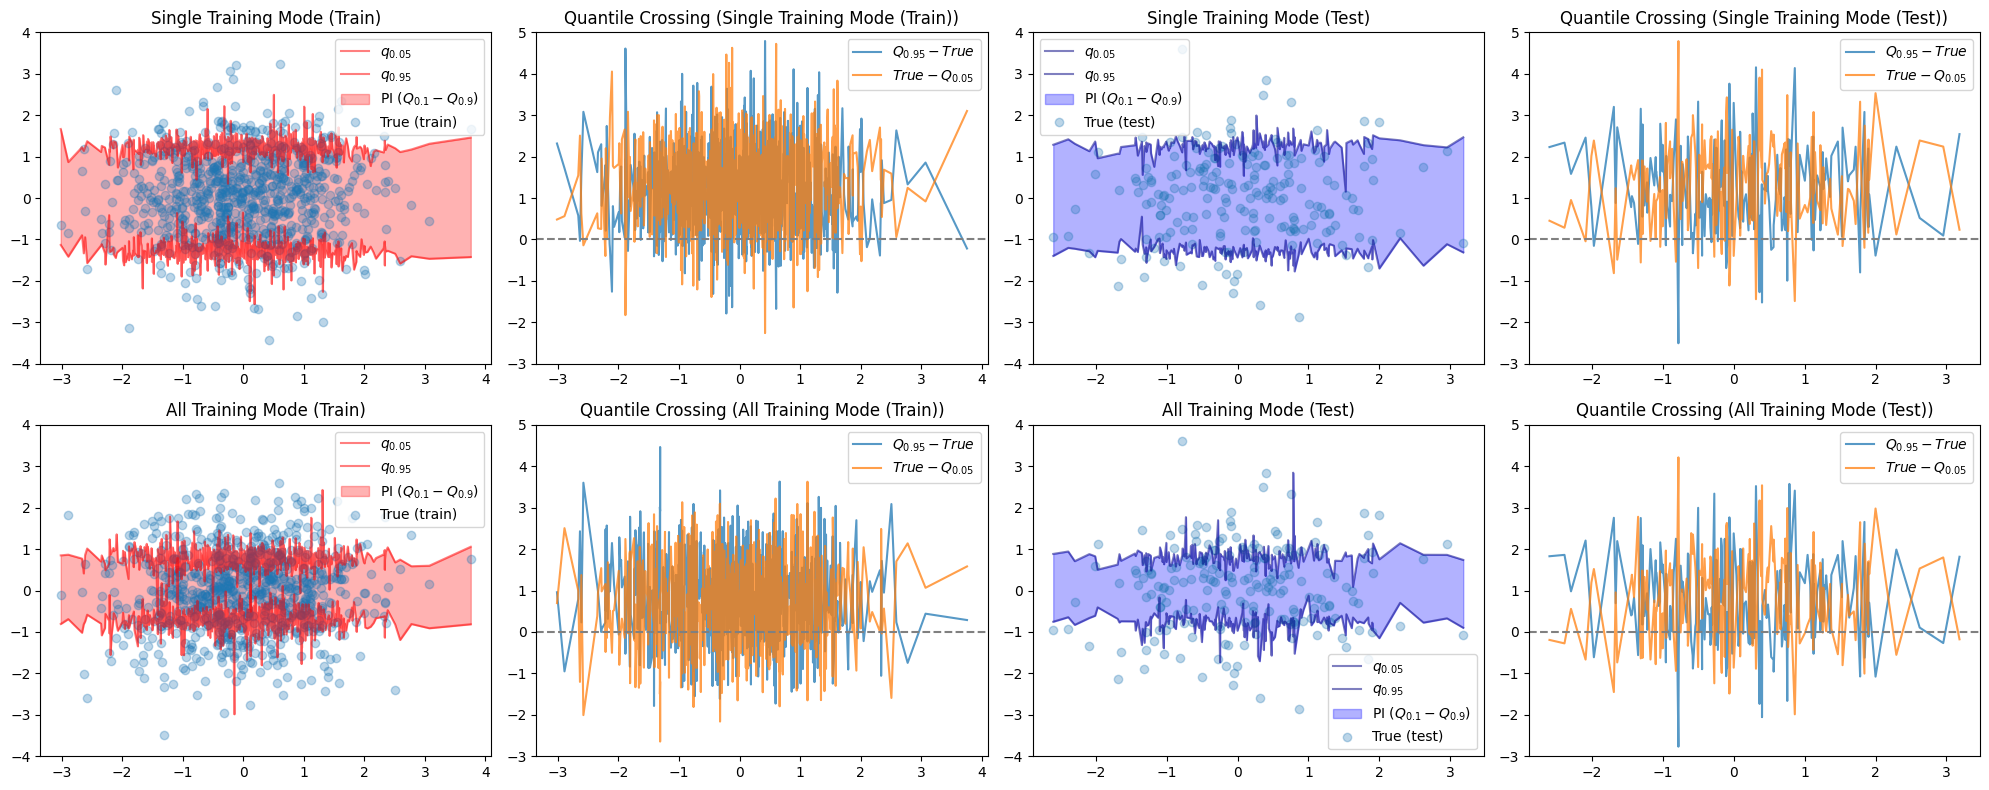

In [106]:
# 시각화
plt.figure(figsize=(20, 8))

# Single Training Mode (Train)
plt.subplot(241)
plt.title("Single Training Mode (Train)")
plt.plot(sorted_x_train, sorted_train_low_single, alpha=0.5, label="$q_{0.05}$", color='red')
plt.plot(sorted_x_train, sorted_train_high_single, alpha=0.5, label="$q_{0.95}$", color='red')
plt.fill_between(sorted_x_train, sorted_train_low_single, sorted_train_high_single, color='red', alpha=0.3, label="PI ($Q_{0.1} - Q_{0.9}$)")

# plt.plot(sorted_x_train, sorted_train_true_single, alpha=0.3, label="True (train)")
plt.scatter(sorted_x_train, sorted_train_true_single, alpha=0.3, label="True (train)")
plt.ylim(-4, 4)
plt.legend()

# Quantile Crossing (Single Training Mode (Train))
plt.subplot(242)
plt.title("Quantile Crossing (Single Training Mode (Train))")
# plt.plot(sorted_x_train, sorted_train_high_all - sorted_train_low_all, label="$Q_{0.95} - Q_{0.05}$", alpha=0.75)
plt.plot(sorted_x_train, sorted_train_high_single - sorted_train_true_single, label="$Q_{0.95} - True$", alpha=0.75)
plt.plot(sorted_x_train, sorted_train_true_single - sorted_train_low_single, label="$True - Q_{0.05}$", alpha=0.75)
plt.axhline(0, ls="--", color="gray")
plt.ylim(-3, 5)
plt.legend()

# Single Training Mode (Test)
plt.subplot(243)
plt.title("Single Training Mode (Test)")
plt.plot(sorted_x_test, sorted_test_low_single, alpha=0.5, label="$q_{0.05}$", color='navy')
plt.plot(sorted_x_test, sorted_test_high_single, alpha=0.5, label="$q_{0.95}$", color='navy')
plt.fill_between(sorted_x_test, sorted_test_low_single, sorted_test_high_single, color='blue', alpha=0.3, label="PI ($Q_{0.1} - Q_{0.9}$)")

# plt.plot(sorted_x_test, sorted_test_true_single, alpha=0.3, label="True (test)")
plt.scatter(sorted_x_test, sorted_test_true_single, alpha=0.3, label="True (test)")
plt.ylim(-4, 4)
plt.legend()

# Quantile Crossing (Single Training Mode (Test))
plt.subplot(244)
plt.title("Quantile Crossing (Single Training Mode (Test))")
# plt.plot(sorted_x_test, sorted_test_high_all - sorted_test_low_all, label="$Q_{0.95} - Q_{0.05}$", alpha=0.75)
plt.plot(sorted_x_test, sorted_test_high_single - sorted_test_true_single, label="$Q_{0.95} - True$", alpha=0.75)
plt.plot(sorted_x_test, sorted_test_true_single - sorted_test_low_single, label="$True - Q_{0.05}$", alpha=0.75)
plt.axhline(0, ls="--", color="gray")
plt.ylim(-3, 5)
plt.legend()

# All Training Mode (Train)
plt.subplot(245)
plt.title("All Training Mode (Train)")
plt.plot(sorted_x_train, sorted_train_low_all, alpha=0.5, label="$q_{0.05}$", color='red')
plt.plot(sorted_x_train, sorted_train_high_all, alpha=0.5, label="$q_{0.95}$", color='red')
plt.fill_between(sorted_x_train, sorted_train_low_all, sorted_train_high_all, color='red', alpha=0.3, label="PI ($Q_{0.1} - Q_{0.9}$)")

# plt.plot(sorted_x_train, sorted_train_true_all, alpha=0.3, label="True (train)")
plt.scatter(sorted_x_train, sorted_train_true_all, alpha=0.3, label="True (train)")
plt.ylim(-4, 4)
plt.legend()

# Quantile Crossing (All Training Mode (Train))
plt.subplot(246)
plt.title("Quantile Crossing (All Training Mode (Train))")
# plt.plot(sorted_x_train, sorted_train_high_all - sorted_train_low_all, label="$Q_{0.95} - Q_{0.05}$", alpha=0.75)
plt.plot(sorted_x_train, sorted_train_high_all - sorted_train_true_all, label="$Q_{0.95} - True$", alpha=0.75)
plt.plot(sorted_x_train, sorted_train_true_all - sorted_train_low_all, label="$True - Q_{0.05}$", alpha=0.75)
plt.axhline(0, ls="--", color="gray")
plt.ylim(-3, 5)
plt.legend()

# All Training Mode (Test)
plt.subplot(247)
plt.title("All Training Mode (Test)")
plt.plot(sorted_x_test, sorted_test_low_all, alpha=0.5, label="$q_{0.05}$", color='navy')
plt.plot(sorted_x_test, sorted_test_high_all, alpha=0.5, label="$q_{0.95}$", color='navy')
plt.fill_between(sorted_x_test, sorted_test_low_all, sorted_test_high_all, color='blue', alpha=0.3, label="PI ($Q_{0.1} - Q_{0.9}$)")

# plt.plot(sorted_x_test, sorted_test_true_all, alpha=0.3, label="True (test)")
plt.scatter(sorted_x_test, sorted_test_true_all, alpha=0.3, label="True (test)")
plt.ylim(-4, 4)
plt.legend()

# Quantile Crossing (All Training Mode (Test))
plt.subplot(248)
plt.title("Quantile Crossing (All Training Mode (Test))")
# plt.plot(sorted_x_test, sorted_test_high_all - sorted_test_low_all, label="$Q_{0.95} - Q_{0.05}$", alpha=0.75)
plt.plot(sorted_x_test, sorted_test_high_all - sorted_test_true_all, label="$Q_{0.95} - True$", alpha=0.75)
plt.plot(sorted_x_test, sorted_test_true_all - sorted_test_low_all, label="$True - Q_{0.05}$", alpha=0.75)
plt.axhline(0, ls="--", color="gray")
plt.ylim(-3, 5)
plt.legend()

plt.tight_layout()
plt.show()

In [108]:
import torch

def dynamic_quantile_adjustment(tau_low, tau_high, cvg_exp, cvg_target, learning_rate=0.05):
    """
    동적 분위수 조정 함수
    - Coverage Error가 크면 분위수를 더 빠르게 조정
    - tau_low, tau_high가 제대로 조정되도록 보장
    """
    cvg_error = cvg_target - cvg_exp  # 목표 Coverage와 실제 Coverage 차이 계산
    tau_adjustment = max(0.005, min(0.15, learning_rate * abs(cvg_error) ** 1.5))  # 변화량 증가

    # 분위수 업데이트
    tau_low_new = max(0.05, min(tau_low - tau_adjustment, tau_high - 0.05))
    tau_high_new = min(0.95, max(tau_high + tau_adjustment, tau_low + 0.05))

    return tau_low_new, tau_high_new


def train_gqnn_adj(model, optimizer, loss_fn, train_loader, train_mode="single", 
                   tau_low=0.1, tau_high=0.9, num_epochs=10000, cvg_target=0.9, lr_tau=0.01):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        tau_low_last = tau_low
        tau_high_last = tau_high
        epoch_cvg_exp = []
        
        for data in train_loader:
            optimizer.zero_grad()
            
            # ✅ 분위수 범위를 `tau_low`, `tau_high`에 맞춰 동적으로 샘플링
            if train_mode == "all":
                taus_low = torch.rand(data.x.size(0), 1) * (tau_high - tau_low) + tau_low
                taus_high = torch.rand(data.x.size(0), 1) * (tau_high - tau_low) + tau_low
            else:
                taus_low = torch.full((data.x.size(0), 1), tau_low)
                taus_high = torch.full((data.x.size(0), 1), tau_high)
            
            y_low_pred = model(data.x, data.edge_index, taus_low)
            y_high_pred = model(data.x, data.edge_index, taus_high)
            
            loss_low = loss_fn(y_low_pred, data.y.view(-1, 1), taus_low)
            loss_high = loss_fn(y_high_pred, data.y.view(-1, 1), taus_high)
            cvg = cvg_loss(data.y.view(-1, 1), y_low_pred, y_high_pred, cvg_target=cvg_target)
            
            # ✅ Coverage Loss 기여도를 증가
            loss = loss_low + loss_high + 10 * cvg  # 기존보다 Coverage Loss 강조
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            # ✅ 배치별 Coverage 값 저장
            batch_cvg_exp = ((data.y.view(-1, 1) >= y_low_pred) & (data.y.view(-1, 1) <= y_high_pred)).float().mean()
            epoch_cvg_exp.append(batch_cvg_exp)

        # ✅ 에포크 전체 평균 Coverage 기반으로 분위수 업데이트
        mean_cvg_exp = torch.stack(epoch_cvg_exp).mean().item()
        tau_low_last, tau_high_last = dynamic_quantile_adjustment(tau_low, tau_high, mean_cvg_exp, cvg_target, lr_tau)

        # ✅ Epoch 로그 출력
        if epoch % (num_epochs // 10) == 0:
            print(f"Epoch {epoch} - Coverage Loss: {cvg.item():.4f}, Coverage Error: {(cvg_target - mean_cvg_exp):.4f}")
            print(f"Epoch: {epoch}, Loss: {total_loss / len(train_loader):.4f}")
            print(f"Updated tau_low: {tau_low_last:.4f}, Updated tau_high: {tau_high_last:.4f}")
    
    return model, tau_low_last, tau_high_last

In [109]:
# Adj 모델 학습 
cvg_target = 0.9
lr_tau = 0.01


# single mode
print('Adj Single Training Mode')
adj_model_single, tau_low_single, tau_high_single = train_gqnn_adj(model, optimizer, loss_fn, train_loader, num_epochs=num_epochs, cvg_target=cvg_target, lr_tau=lr_tau)

adj_tr_true_single, adj_tr_low_single, adj_tr_high_single = test_gqnn(adj_model_single, train_loader, tau_low=tau_low_single, tau_high=tau_high_single)
adj_tr_coverage_single = evaluate_coverage(torch.tensor(adj_tr_true_single), torch.tensor(adj_tr_low_single), torch.tensor(adj_tr_high_single))
adj_tr_pi_single = evaluate_pi(torch.tensor(adj_tr_low_single), torch.tensor(adj_tr_high_single))

adj_ts_true_single, adj_ts_low_single, adj_ts_high_single = test_gqnn(adj_model_single, test_loader, tau_low=tau_low_single, tau_high=tau_high_single)
adj_ts_coverage_single = evaluate_coverage(torch.tensor(adj_ts_true_single), torch.tensor(adj_ts_low_single), torch.tensor(adj_ts_high_single))
adj_ts_pi_single = evaluate_pi(torch.tensor(adj_ts_low_single), torch.tensor(adj_ts_high_single))

print(f"Coverage_single training mode: {adj_tr_coverage_single:.4f}, {adj_ts_coverage_single:.4f}")
print(f"PI_single training mode: {adj_tr_pi_single:.4f}, {adj_ts_pi_single:.4f}")
print('-' * 100)

# all mode
print('Adj All Training Mode')
adj_model_all, tau_low_all, tau_high_all = train_gqnn_adj(model, optimizer_all, loss_fn, train_loader, train_mode="all", num_epochs=num_epochs, cvg_target=cvg_target, lr_tau=lr_tau)

adj_tr_true_all, adj_tr_low_all, adj_tr_high_all = test_gqnn(adj_model_all, train_loader, tau_low=tau_low_all, tau_high=tau_high_all)
adj_tr_coverage_all = evaluate_coverage(torch.tensor(adj_tr_true_all), torch.tensor(adj_tr_low_all), torch.tensor(adj_tr_high_all))
adj_tr_pi_all = evaluate_pi(torch.tensor(adj_tr_low_all), torch.tensor(adj_tr_high_all))

adj_ts_true_all, adj_ts_low_all, adj_ts_high_all = test_gqnn(adj_model_all, test_loader, tau_low=tau_low_all, tau_high=tau_high_all)
adj_ts_coverage_all = evaluate_coverage(torch.tensor(adj_ts_true_all), torch.tensor(adj_ts_low_all), torch.tensor(adj_ts_high_all))
adj_ts_pi_all = evaluate_pi(torch.tensor(adj_ts_low_all), torch.tensor(adj_ts_high_all))

print(f"Coverage_all training mode: {adj_tr_coverage_all:.4f}, {adj_ts_coverage_all:.4f}")
print(f"PI_all training mode: {adj_tr_pi_all:.4f}, {adj_ts_pi_all:.4f}")

Adj Single Training Mode
Epoch 0 - Coverage Loss: 0.1075, Coverage Error: 0.3315
Epoch: 0, Loss: 1.4982
Updated tau_low: 0.0950, Updated tau_high: 0.9050
Epoch 50 - Coverage Loss: 0.1095, Coverage Error: 0.3314
Epoch: 50, Loss: 1.4983
Updated tau_low: 0.0950, Updated tau_high: 0.9050
Epoch 100 - Coverage Loss: 0.1106, Coverage Error: 0.3315
Epoch: 100, Loss: 1.4985
Updated tau_low: 0.0950, Updated tau_high: 0.9050
Epoch 150 - Coverage Loss: 0.1097, Coverage Error: 0.3315
Epoch: 150, Loss: 1.4985
Updated tau_low: 0.0950, Updated tau_high: 0.9050
Epoch 200 - Coverage Loss: 0.1122, Coverage Error: 0.3314
Epoch: 200, Loss: 1.4987
Updated tau_low: 0.0950, Updated tau_high: 0.9050
Epoch 250 - Coverage Loss: 0.1120, Coverage Error: 0.3315
Epoch: 250, Loss: 1.4988
Updated tau_low: 0.0950, Updated tau_high: 0.9050
Epoch 300 - Coverage Loss: 0.1052, Coverage Error: 0.3315
Epoch: 300, Loss: 1.4986
Updated tau_low: 0.0950, Updated tau_high: 0.9050
Epoch 350 - Coverage Loss: 0.1175, Coverage Error:

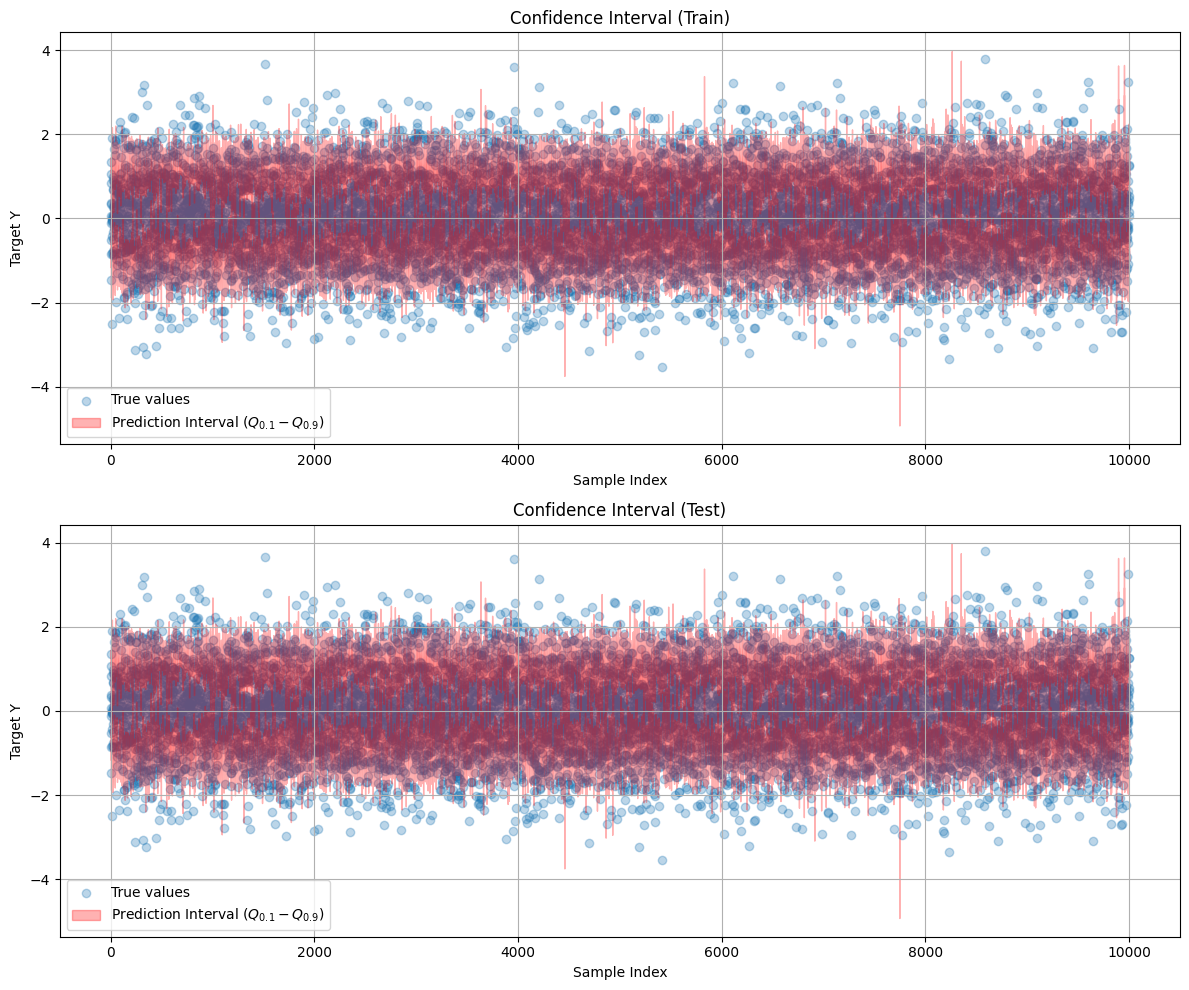

In [77]:
# 데이터 정렬 (샘플 인덱스 유지)
sorted_indices_train = np.argsort(y_true.flatten())
sorted_y_train = y_true[sorted_indices_train].flatten()
sorted_y_low_train = y_low[sorted_indices_train].flatten()
sorted_y_high_train = y_high[sorted_indices_train].flatten()

sorted_indices_test = np.argsort(y_true.flatten())
sorted_y_test = y_true[sorted_indices_test].flatten()
sorted_y_low_test = y_low[sorted_indices_test].flatten()
sorted_y_high_test = y_high[sorted_indices_test].flatten()

# 원래 샘플 순서 유지
sample_indices_train = np.arange(len(y_true))  # 학습 샘플 인덱스
sample_indices_test = np.arange(len(y_true))  # 테스트 샘플 인덱스

# 서브플롯 설정
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# 🔹 학습 데이터 시각화 (왼쪽 그래프)
ax[0].set_title("Confidence Interval (Train)")
ax[0].scatter(sample_indices_train, y_true.flatten(), alpha=0.3, label="True values")
ax[0].fill_between(sample_indices_train, y_low.flatten(), y_high.flatten(),
                   color='red', alpha=0.3, label="Prediction Interval ($Q_{0.1} - Q_{0.9}$)")
# ax[0].plot(sample_indices_train, (y_low.flatten() + y_high.flatten()) / 2, 
#            color="blue", linewidth=2, label="Predicted Mean ($Q_{0.5}$)")
ax[0].set_xlabel("Sample Index")
ax[0].set_ylabel("Target Y")
ax[0].legend()
ax[0].grid(True)

# 🔹 테스트 데이터 시각화 (오른쪽 그래프)
ax[1].set_title("Confidence Interval (Test)")
ax[1].scatter(sample_indices_test, y_true.flatten(), alpha=0.3, label="True values")
ax[1].fill_between(sample_indices_test, y_low.flatten(), y_high.flatten(),
                   color='red', alpha=0.3, label="Prediction Interval ($Q_{0.1} - Q_{0.9}$)")
# ax[1].plot(sample_indices_test, (y_low.flatten() + y_high.flatten()) / 2, 
#            color="blue", linewidth=2, label="Predicted Mean ($Q_{0.5}$)")
ax[1].set_xlabel("Sample Index")
ax[1].set_ylabel("Target Y")
ax[1].legend()
ax[1].grid(True)

# 전체 레이아웃 정리
plt.tight_layout()
plt.show()


In [ ]:
# Conformal Prediction
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

def train_gcn(model, data):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
    loss_fn = F.mse_loss
    
    model.train()
    epochs = 1000
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
    
    return model

def cqr_conformal_interval(cal_labels, cal_lower, cal_upper, test_labels, test_lower, test_upper, alpha=0.1):
    """CQR을 활용한 신뢰 구간 계산"""
    cal_scores = np.maximum(cal_labels - cal_upper, cal_lower - cal_labels)
    qhat = np.quantile(cal_scores, np.ceil((len(cal_labels) + 1) * (1 - alpha)) / len(cal_labels), method='higher')
    
    pred_intervals = [test_lower - qhat, test_upper + qhat]
    coverage = ((test_labels >= pred_intervals[0]) & (test_labels <= pred_intervals[1])).mean()
    efficiency = np.mean(test_upper + qhat - (test_lower - qhat))
    
    return pred_intervals, coverage, efficiency

In [81]:
def coverage_loss(y_true, y_low, y_high, target_coverage=0.9):
    """
    목표 Coverage를 유지하기 위한 손실 함수.
    """
    coverage_exp = ((y_true >= y_low) & (y_true <= y_high)).float().mean()
    return (coverage_exp - target_coverage) ** 2

def piw_loss(y_low, y_high):
    """
    신뢰 구간 폭(PIW)을 최소화하는 손실 함수.
    """
    return torch.mean(y_high - y_low)  # 구간 폭의 평균을 최소화

def dynamic_quantile_adjustment(q_low, q_high, coverage_exp, coverage_target, learning_rate=0.01):
    """
    실제 Coverage가 목표 Coverage에 맞도록 분위수를 동적으로 조정하는 함수.
    """
    coverage_error = coverage_target - coverage_exp  # 목표 Coverage와 실제 Coverage 차이 계산
    q_low = q_low - learning_rate * coverage_error   # Coverage 부족 시 하한값 조정
    q_high = q_high + learning_rate * coverage_error # Coverage 부족 시 상한값 증가
    return q_low, q_high





def total_loss(y_true, y_preds, edge_index, quantiles, target_coverage=0.9, edge_weight=0.1, piw_weight=0.1, coverage_weight=1.0):
    """
    최종 손실 함수:
    - Quantile Loss (기본 분위수 손실)
    - Graph Regularization (이웃 노드 간 Smoothness 유지)
    - Coverage Loss (Coverage 보장)
    - PIW Loss (신뢰 구간 폭 최적화)
    """
    y_low, y_mid, y_high = y_preds  # 예측된 분위수 값 분리

    # 분위수 손실 (Quantile Loss)
    loss_q = sum(QuantileLoss()(y_pred, y_true, q) for y_pred, q in zip(y_preds, quantiles))

    # 그래프 정규화 (Graph Smoothness Loss)
    src, dst = edge_index
    loss_graph = edge_weight * torch.mean((y_preds[1][src] - y_preds[1][dst]) ** 2)

    # Coverage 보장 손실
    loss_coverage = coverage_weight * coverage_loss(y_true, y_low, y_high, target_coverage)

    # 신뢰 구간 폭(PIW) 최적화 손실
    loss_piw = piw_weight * piw_loss(y_low, y_high)

    return loss_q + loss_graph + loss_coverage + loss_piw

In [38]:
# 학습 함수
# Joint Quantile Learning 적용 (Multi-Quantile trainig)
# 여러 분위수를 동시에 학습하여 분위수 교차 문제 완화

def train_gqnn(data, device, target_coverage=0.9, q="all"):    
    model = GCNQuantile(in_channels=data.x.size(1), hidden_channels=16).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
    data = data.to(device)

    # 초기 분위수 설정 (q_low: 10%, q_high: 90%)
    q_low, q_high = 0.1, 0.9
    learning_rate = 0.01  # 분위수 조정 속도

    epochs = 1000
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # 여러 분위수를 동시에 학습 (Joint Quantile Training)
        if q == "all":
            taus = torch.rand(data.x.size(0), 1).to(device)
        else:
            taus = torch.full((data.x.size(0), 1), q, device=device)

        y_preds = model(data.x, data.edge_index, taus)
        y_low = y_preds[:, 0]  # 첫 번째 열이 10% 분위수
        y_mid = y_preds[:, 1]  # 두 번째 열이 50% 분위수
        y_high = y_preds[:, 2]  # 세 번째 열이 90% 분위수

        # 손실 계산 (Coverage + PIW 최적화 포함)
        loss = total_loss(data.y, y_preds, data.edge_index, model.quantiles)

        loss.backward()
        optimizer.step()

        # 현재 Coverage 측정
        coverage_exp = evaluate_coverage(data.y, y_low, y_high)

        # Coverage 보장: 분위수 업데이트
        q_low, q_high = dynamic_quantile_adjustment(q_low, q_high, coverage_exp, target_coverage, learning_rate)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Coverage = {coverage_exp:.4f}, PIW = {(y_high - y_low).mean().item():.4f}")

    return model

In [39]:
# 사용할 데이터셋 선택 (Cora, Citeseer, Pubmed)
dataset_name = "Cora"  # "Citeseer", "Pubmed", "Computers", "Photo" 등도 가능
dataset = Planetoid(root='/tmp/' + dataset_name, name=dataset_name, transform=T.NormalizeFeatures())

# 데이터셋 불러오기
data = dataset[0]
data.y = data.y.float().view(-1, 1)  # 타겟 값을 float형으로 변환 (회귀 수행 가능하도록 변경)

In [40]:
print(f"Dataset: {dataset_name}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features per node: {data.num_features}")
print(f"Number of classes: {dataset.num_classes}")  # 원래 분류 문제이므로 클래스 개수 출력

Dataset: Cora
Number of nodes: 2708
Number of edges: 10556
Number of features per node: 1433
Number of classes: 7


In [41]:
# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

# 모델 학습 실행 (Coverage 보장 & 신뢰 구간 최적화 포함)
model = train_gqnn(data, device, q="all")

ValueError: too many values to unpack (expected 3)